# Audio MNIST
### RNN
#### 20213013 김어진


## 1. 데이터 분석

#### Audio MNIST 데이터셋 특징
- 목표: 음성 신호를 통해 0부터 9까지의 숫자를 인식하는 모델을 훈련.
- 형태: 각 숫자(0~9) 음성 파일은 WAV 형식으로 저장되어 있습니다. 각 음성 파일은 숫자를 발음한 오디오 클립.
- 샘플: 각 오디오 파일은 고유한 숫자 음성을 포함하고 있으며, 일반적으로 각 숫자에 대해 여러 샘플이 존재.
    - 총 30,000개의 샘플
    - 각 샘플은 2개의 요소를 가진 튜플:
        - 오디오 파형 (shape: [1, 16000]) - 1채널, 16000 샘플
        - 레이블 (단일 정수)

#### 구성 요소
- 샘플링 레이트: 일반적으로 음성 데이터는 일정한 샘플링 레이트. Audio MNIST의 경우, 보통 16kHz(16,000 샘플/초) 샘플링 레이트로 저장.
- 길이: 각 오디오 클립의 길이는 일정하지 않으며, 대체로 몇 백 밀리초 정도.
레이블: 각 음성 파일은 해당 숫자를 레이블(0~9)화한 음성.

#### waveform / mel-spectrogram
- waveform: 오디오 신호의 시간 영역 표현. 시간에 따른 음압의 변화를 시각화.
- mel-spectrogram: 주파수 영역 표현. 음성 신호를 주파수 대역으로 분해하고, 각 주파수 대역의 에너지 크기를 시각화.

#### 6가지 모델 구성
- Waveform + RNN
- Waveform + LSTM
- Waveform + GRU
- Mel-Spectrogram + RNN
- Mel-Spectrogram + LSTM
- Mel-Spectrogram + GRU

## 데이터 로드

In [1]:
# 데이터 로드 및 기본 설정
import torch
import torch.nn as nn
import torch.optim as optim
import random
import torchaudio
import torchaudio.transforms as T
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# audio_mnist.pt 파일 로드
file_path = r"C:\Users\chosun\Downloads\audio_mnist.pt"  # raw string 사용
audio_data = torch.load(file_path)

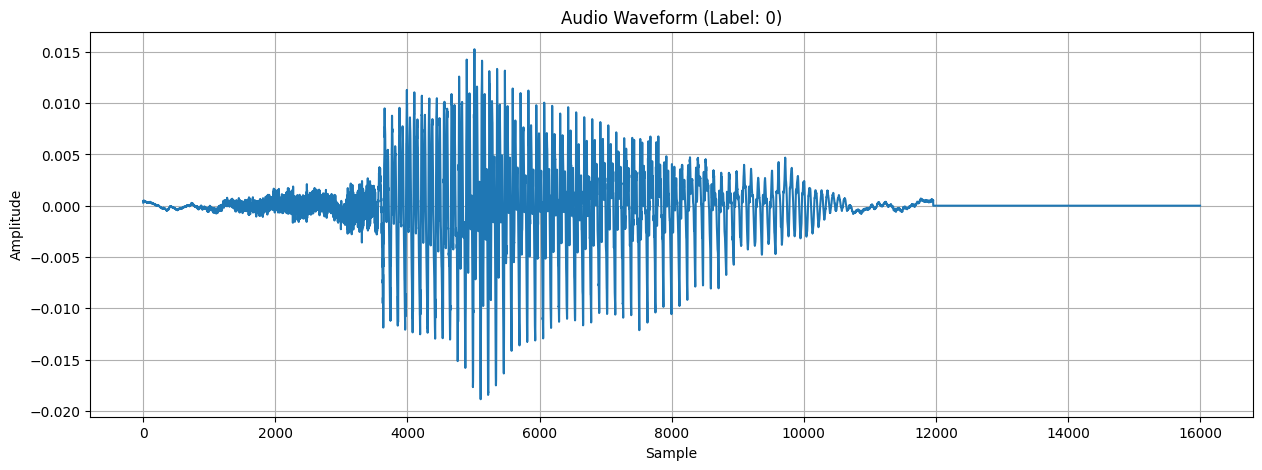

Label: 0
Waveform min: -0.019
Waveform max: 0.015
Waveform mean: -0.000


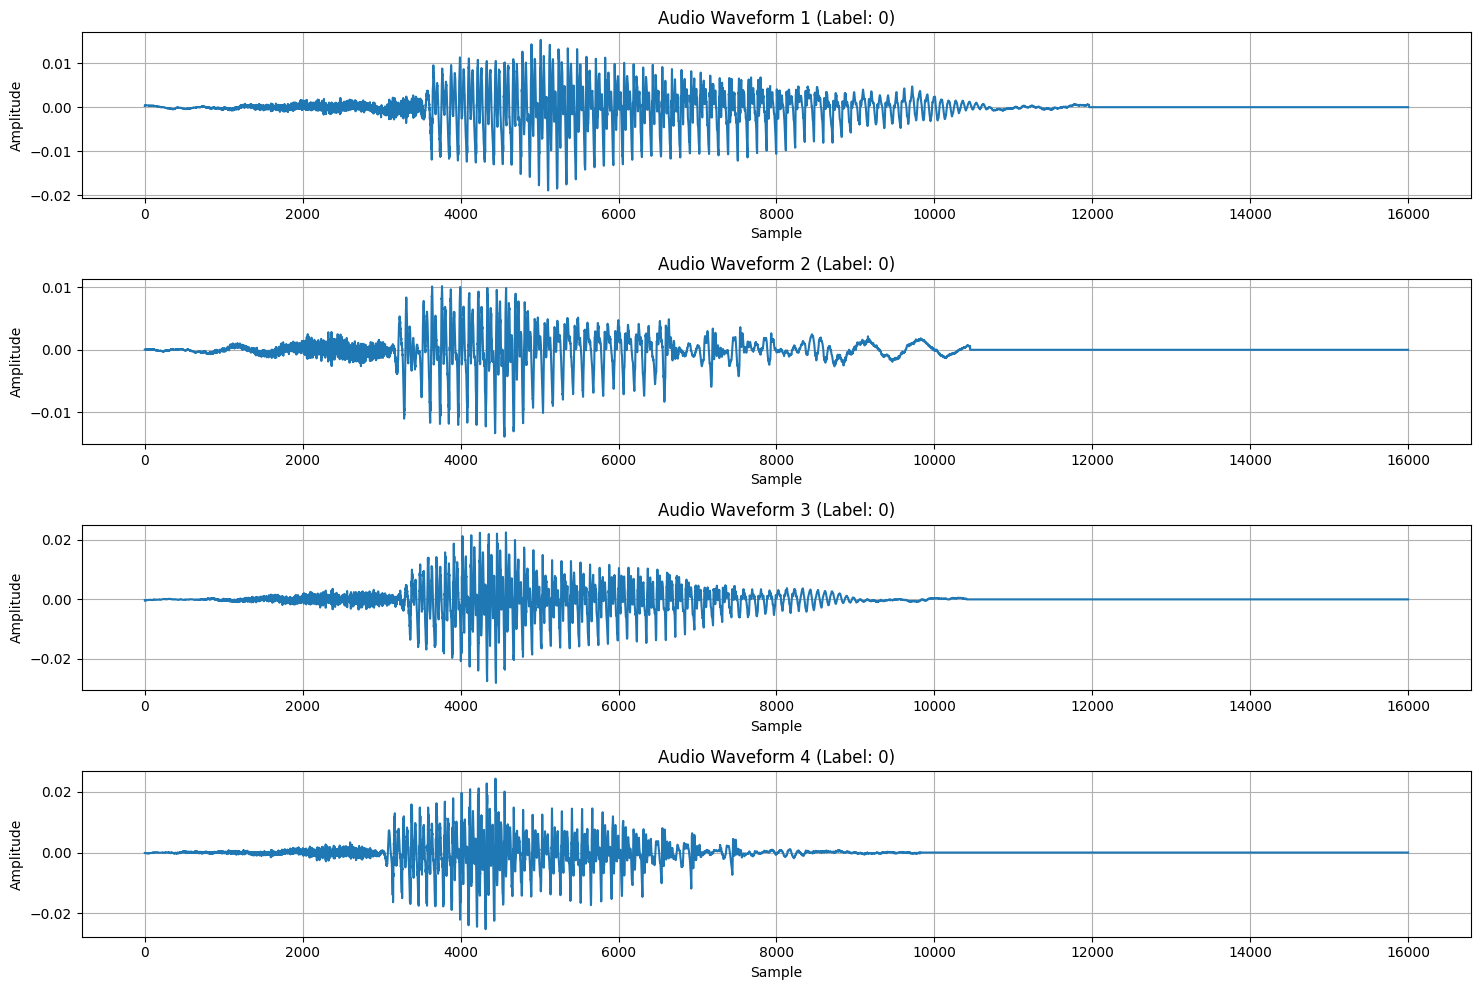

In [2]:
import torch
import matplotlib.pyplot as plt

# 첫 번째 샘플 가져오기
waveform, label = audio_data[0]  # 파형과 레이블 언패킹

# 파형 데이터 준비 (shape 변환: [1, 16000] -> [16000])
waveform = waveform.squeeze()  # 불필요한 차원 제거

# 시각화
plt.figure(figsize=(15, 5))
plt.plot(waveform.numpy())
plt.title(f'Audio Waveform (Label: {label.item()})')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

# 기본 통계 출력
print(f"Label: {label.item()}")
print(f"Waveform min: {waveform.min().item():.3f}")
print(f"Waveform max: {waveform.max().item():.3f}")
print(f"Waveform mean: {waveform.mean().item():.3f}")

# 여러 샘플 시각화 (예: 첫 4개 샘플)
plt.figure(figsize=(15, 10))

for i in range(4):
    waveform, label = audio_data[i]
    waveform = waveform.squeeze()
    
    plt.subplot(4, 1, i+1)
    plt.plot(waveform.numpy())
    plt.title(f'Audio Waveform {i+1} (Label: {label.item()})')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.grid(True)

plt.tight_layout()
plt.show()

고유한 레이블: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

각 레이블 별 샘플 수:
레이블 0: 3000 샘플
레이블 1: 3000 샘플
레이블 2: 3000 샘플
레이블 3: 3000 샘플
레이블 4: 3000 샘플
레이블 5: 3000 샘플
레이블 6: 3000 샘플
레이블 7: 3000 샘플
레이블 8: 3000 샘플
레이블 9: 3000 샘플


c:\Users\chosun\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\axes\_axes.py:8089: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


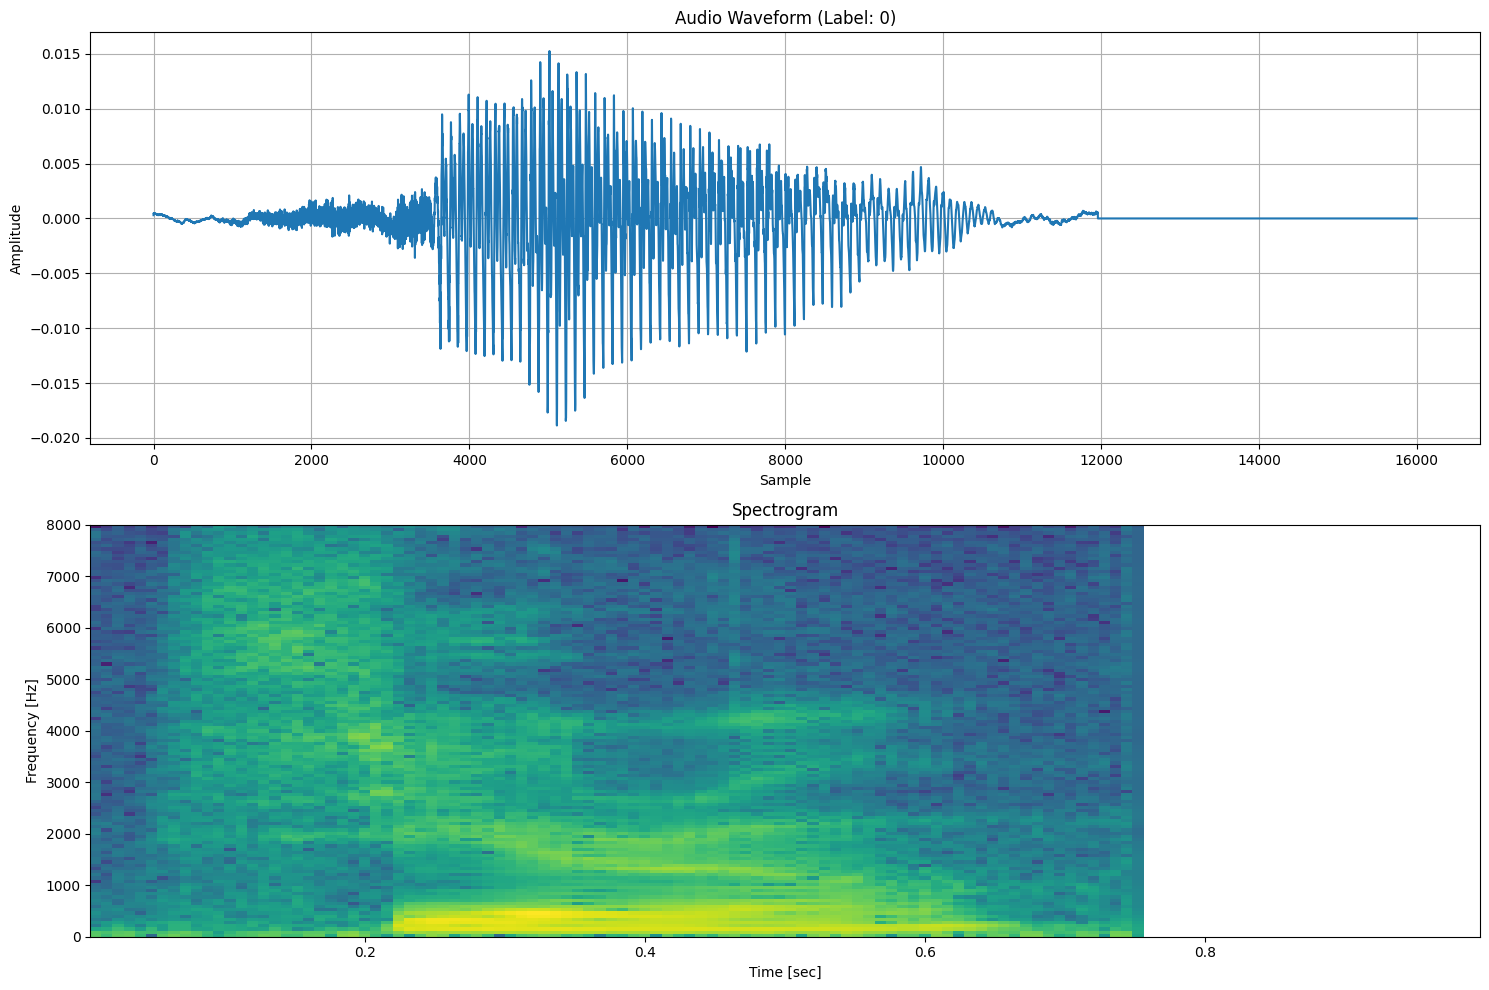

In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# 데이터 특성 분석
unique_labels = set()
label_counts = {}

# 모든 레이블 확인
for _, label in audio_data:
    label = label.item()
    unique_labels.add(label)
    label_counts[label] = label_counts.get(label, 0) + 1

print("고유한 레이블:", sorted(list(unique_labels)))
print("\n각 레이블 별 샘플 수:")
for label in sorted(label_counts.keys()):
    print(f"레이블 {label}: {label_counts[label]} 샘플")

# 파형의 시간-주파수 분석
waveform, label = audio_data[0]
waveform = waveform.squeeze().numpy()

plt.figure(figsize=(15, 10))

# 파형 그래프
plt.subplot(2, 1, 1)
plt.plot(waveform)
plt.title(f'Audio Waveform (Label: {label.item()})')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.grid(True)

# 스펙트로그램
plt.subplot(2, 1, 2)
plt.specgram(waveform, Fs=16000)  # 16kHz sampling rate
plt.title('Spectrogram')
plt.xlabel('Time [sec]')
plt.ylabel('Frequency [Hz]')

plt.tight_layout()
plt.show()

## 데이터 전처리(Mel)


In [4]:
# MEL 스펙트로그램 처리
def preprocess_mel(waveform, sample_rate=16000, n_mels=64, target_length=400):
    # 속도 변화 추가
    speed_factor = random.uniform(0.95, 1.05)  # 속도 변화 비율
    new_length = int(len(waveform) / speed_factor)  # 새로운 길이
    waveform = torch.nn.functional.interpolate(waveform.unsqueeze(0).unsqueeze(0), size=new_length, mode='linear').squeeze()
    
    # 패딩 처리: 길이를 target_length에 맞추기
    if len(waveform) < target_length:
        waveform = torch.cat([waveform, torch.zeros(target_length - len(waveform))])
    else:
        waveform = waveform[:target_length]
    
    # MEL 스펙트로그램 변환
    mel_transform = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, n_mels=n_mels)
    mel_spec = mel_transform(waveform)
    return mel_spec

In [5]:
# 데이터셋 클래스
class AudioMNISTDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        waveform, label = self.data[idx]
        if self.transform:
            waveform = self.transform(waveform)
        return waveform, label

## RNN 모델

In [6]:
# RNN 모델 정의
class AudioRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(AudioRNN, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x, _ = self.rnn(x)
        x = x[:, -1, :]  # 마지막 시점의 출력
        x = self.fc(x)
        return x

## LSTM 모델

In [7]:
# LSTM 모델 정의
class AudioLSTM(nn.Module):
    def __init__(self, input_size=64, hidden_size=128, num_layers=2, num_classes=10):
        super(AudioLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=input_size,
                           hidden_size=hidden_size,
                           num_layers=num_layers,
                           batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = x.transpose(1, 2)
        out, (_, _) = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

## GRU 모델

In [8]:
# GRU 모델 정의
class AudioGRU(nn.Module):
    def __init__(self, input_size=64, hidden_size=128, num_layers=2, num_classes=10):
        super(AudioGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size=input_size,
                         hidden_size=hidden_size,
                         num_layers=num_layers,
                         batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = x.transpose(1, 2)
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out


## 손실 함수 및 옵티마이저

In [9]:
# 손실 함수 및 옵티마이저 설정
def cross_entropy_loss():
    return nn.CrossEntropyLoss()

def adam_optimizer(model, learning_rate=0.001):
    return optim.Adam(model.parameters(), lr=learning_rate)

## 학습 평가

In [10]:
# 모델 평가 함수
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return test_loss / len(test_loader), accuracy


: 

## 모델 학습

In [11]:
# 데이터 로드 및 준비
from torch.utils.data import DataLoader, TensorDataset

# 데이터를 TensorDataset으로 변환 (예시로 20%를 테스트셋으로 사용)
train_size = int(0.8 * len(audio_data))  # 80% 훈련용
test_size = len(audio_data) - train_size  # 20% 테스트용
train_data, test_data = torch.utils.data.random_split(audio_data, [train_size, test_size])

# DataLoader 준비
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# 모델 인스턴스 생성 (예: AudioRNN)
model = AudioRNN(input_size=64, hidden_size=128, num_layers=2, num_classes=10)

# 손실 함수와 옵티마이저 설정
criterion = cross_entropy_loss()
optimizer = adam_optimizer(model, learning_rate=0.001)

# 모델 훈련
num_epochs = 30
train_loss_history = []
test_loss_history = []
accuracy_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        # 배치 내 각 waveform에 대해 MEL 스펙트로그램 계산
        inputs = torch.stack([preprocess_mel(waveform.squeeze()) for waveform in inputs])
        inputs = inputs.permute(0, 2, 1)  # [batch_size, time_steps, n_mels] 형태로 차원 변경
        
        optimizer.zero_grad()
        outputs = model(inputs)  # 모델 예측
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    # 훈련 손실 기록
    train_loss_history.append(running_loss / len(train_loader))
    
    # 테스트 손실 및 정확도 계산
    test_loss, accuracy = evaluate_model(model, test_loader, criterion)
    test_loss_history.append(test_loss)
    accuracy_history.append(accuracy)

    # 10 에폭마다 출력
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss_history[-1]:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%')



## 예측 및 결과

In [68]:
# 최종 손실 및 정확도 출력
print(f'Final Train Loss: {train_loss_history[-1]:.4f}')
print(f'Final Test Loss: {test_loss_history[-1]:.4f}')
print(f'Final Test Accuracy: {accuracy_history[-1]:.2f}%')

# 훈련 및 테스트 손실 시각화
plt.figure(figsize=(12, 6))
plt.plot(range(num_epochs), train_loss_history, label='Train Loss')
plt.plot(range(num_epochs), test_loss_history, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Test Loss')
plt.legend()
plt.grid(True)
plt.show()

# 테스트 정확도 시각화
plt.figure(figsize=(12, 6))
plt.plot(range(num_epochs), accuracy_history, label='Test Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()